In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="1"

def my_mnist_train_batch(size) :
    m = 500
    data = []
    for i in range(1000) :
        number = np.random.randint(5)
        image, label = mnist.train.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def my_mnist_test_batch(size, number = 0) :
    m = 500
    data = []
    for i in range(1000) :
        image, label = mnist.test.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

file_name = 'proto_1'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)

def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse) :
        
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,1024,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,128,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,64,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,1024,[4,4], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,512,[4,4], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,256,[4,4], strides=(2,2),padding = 'same')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,128,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,64,[3,3], strides=(1,1),padding = 'valid')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid')
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def simple_D(x,isTrain=True,reuse = False) :
    
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,28,28,1)


        conv1 = tf.layers.conv2d(x,64,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,128,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,256,[5,5], strides=(1,1),padding = 'valid')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        conv4 = tf.layers.conv2d(r3,512,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        conv5 = tf.layers.conv2d(r4,1024,[4,4], strides=(2,2),padding = 'same')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid')
        r6 = tf.nn.sigmoid(conv6)#1*1*1


        return r6
def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)


        conv1 = tf.layers.conv2d(x,64,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,128,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain), name = name)#128*20*20

  
        #conv3 = tf.layers.conv2d(r2,256,[5,5], strides=(1,1),padding = 'valid')
        #r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        #conv4 = tf.layers.conv2d(r3,512,[4,4], strides=(2,2),padding = 'same')
        #r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        #conv5 = tf.layers.conv2d(r4,1024,[4,4], strides=(2,2),padding = 'same')
        #r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        #conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid')
        #r6 = tf.nn.sigmoid(conv6)#1*1*1


        return r2



Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
lr = 0.0001

z = tf.placeholder(tf.float32,shape=(None,1,1,100),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='u')
ano_y = tf.placeholder(tf.float32, shape = (1, 28,28,1),name='ano_y')

ano_z = tf.get_variable('ano_z', shape = [1, 1, 1, 100], dtype = tf.float32, 
        initializer = tf.truncated_normal_initializer(mean= 0.0, stddev=0.1))

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 
    
G_z = simple_G(z,name='G_z')

D_real = simple_D(u,isTrain)
D_fake = simple_D(G_z,isTrain,reuse=True)


img_z = residual_loss_G(ano_z, name ='img_z')

feature_y = feature_extractor_D(ano_y, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(img_z, reuse = True, name ='feature_z')


feature_loss = tf.reduce_mean(tf.abs(feature_y-feature_z),name = 'feature_loss')
D_real_loss = tf.reduce_mean(-0.5*tf.log(D_real + 1e-8),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-0.5*tf.log(1 - D_fake + 1e-8),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-0.5*(tf.log(D_fake + 1e-8)),name='G_loss')
residual_loss = tf.reduce_mean(tf.abs(img_z - ano_y), name = 'residual_loss')

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
ano_vars = [var for var in T_vars if var.name.startswith('ano')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(lr,).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars, name='G_optim')
    
residual_optim = tf.train.AdamOptimizer(0.001).minimize(residual_loss, var_list=ano_vars, name='residual_optim')


D_e : 0.928131, D_real_e : 0.553180, D_fake_e : 0.374951, G_e : 1.521383
D_e : 1.398702, D_real_e : 0.293899, D_fake_e : 1.109509, G_e : 7.670171
D_e : 0.892587, D_real_e : 0.211538, D_fake_e : 0.169873, G_e : 7.488940
D_e : 0.642945, D_real_e : 0.075613, D_fake_e : 0.065552, G_e : 5.981827
D_e : 0.526819, D_real_e : 0.104229, D_fake_e : 0.073051, G_e : 5.182740
D_e : 0.457612, D_real_e : 0.100495, D_fake_e : 0.079596, G_e : 5.182698
D_e : 0.402924, D_real_e : 0.059178, D_fake_e : 0.069762, G_e : 5.165981
D_e : 0.376457, D_real_e : 0.115711, D_fake_e : 0.101677, G_e : 4.916242
D_e : 0.341660, D_real_e : 0.054458, D_fake_e : 0.043278, G_e : 4.793045
D_e : 0.309776, D_real_e : 0.029661, D_fake_e : 0.024720, G_e : 4.714148
D_e : 0.300331, D_real_e : 0.120939, D_fake_e : 0.094295, G_e : 4.534214
D_e : 0.292347, D_real_e : 0.115850, D_fake_e : 0.096576, G_e : 4.410500
D_e : 0.280238, D_real_e : 0.090359, D_fake_e : 0.056564, G_e : 4.311230
D_e : 0.268869, D_real_e : 0.073450, D_fake_e : 0.0

D_e : 0.236828, D_real_e : 0.123951, D_fake_e : 0.067191, G_e : 2.030646
D_e : 0.236651, D_real_e : 0.139219, D_fake_e : 0.077447, G_e : 2.027819
D_e : 0.235773, D_real_e : 0.092164, D_fake_e : 0.043524, G_e : 2.025781
D_e : 0.235373, D_real_e : 0.118083, D_fake_e : 0.071298, G_e : 2.021852
D_e : 0.235089, D_real_e : 0.130790, D_fake_e : 0.071409, G_e : 2.019123
D_e : 0.234880, D_real_e : 0.146452, D_fake_e : 0.063938, G_e : 2.015810
D_e : 0.234211, D_real_e : 0.101686, D_fake_e : 0.053528, G_e : 2.014223
D_e : 0.233681, D_real_e : 0.109439, D_fake_e : 0.061170, G_e : 2.012560
D_e : 0.233445, D_real_e : 0.124324, D_fake_e : 0.080787, G_e : 2.009917
D_e : 0.233916, D_real_e : 0.177092, D_fake_e : 0.113832, G_e : 2.006902
D_e : 0.234472, D_real_e : 0.201511, D_fake_e : 0.100780, G_e : 2.003664
D_e : 0.234281, D_real_e : 0.142002, D_fake_e : 0.068799, G_e : 1.999411
D_e : 0.234025, D_real_e : 0.143649, D_fake_e : 0.058620, G_e : 1.998358
D_e : 0.233598, D_real_e : 0.114613, D_fake_e : 0.0

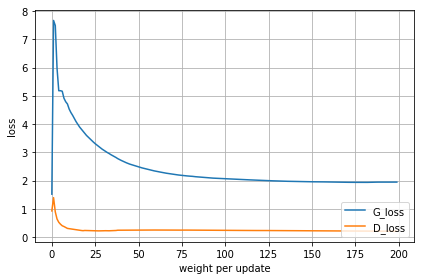

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,100))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(20000) :

        train_images = my_mnist_train_batch(100) 
        u_ = np.reshape(train_images,(-1,28,28,1)) 
        z_ = np.random.normal(0,1,size=(100,1,1,100))


        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,784)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [15]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

residual_optim = sess.graph.get_operation_by_name("residual_optim")





INFO:tensorflow:Restoring parameters from proto_1/para.cktp


In [16]:
im = my_mnist_test_batch(1, number = 7) 

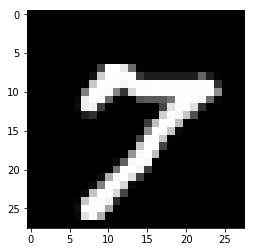

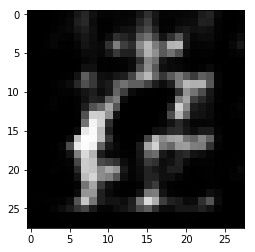

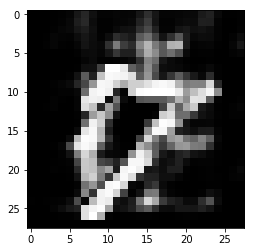

0.716567 0.1725


In [17]:
 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [18]:
for i in range(5000) :
    _ , loss = sess.run([residual_optim,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss)

0.1725
0.122353
0.101845
0.0869388
0.0790101
0.0724706
0.0662312
0.0615963
0.0579692
0.0552698
0.0530784
0.0512184
0.0496937
0.0483209
0.047135
0.0459961
0.0450231
0.0441358
0.0433216
0.0425848
0.0420635
0.0414332
0.0409225
0.0404155
0.0399776
0.0395603
0.0391288
0.0387372
0.0384486
0.0380936
0.0378371
0.0376217
0.0374029
0.0371941
0.0369928
0.036838
0.0366605
0.0364946
0.0363344
0.0362447
0.0360467
0.0359043
0.0357994
0.0356961
0.0356127
0.035447
0.0352908
0.0351946
0.0350891
0.0349734


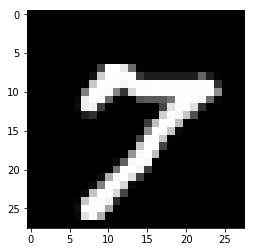

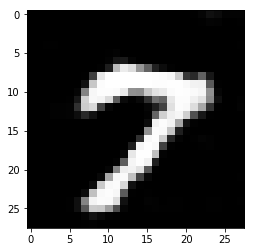

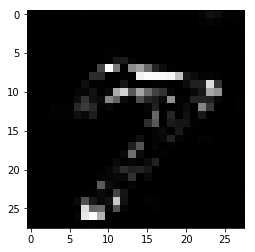

0.201372 0.0348854


In [19]:
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [20]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

residual_optim = sess.graph.get_operation_by_name("residual_optim")




INFO:tensorflow:Restoring parameters from proto_1/para.cktp


In [21]:
im = my_mnist_test_batch(1, number = 4) 

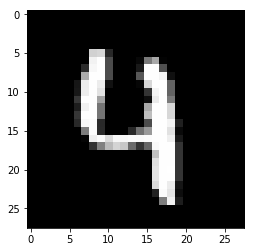

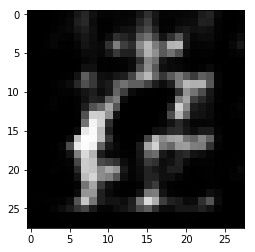

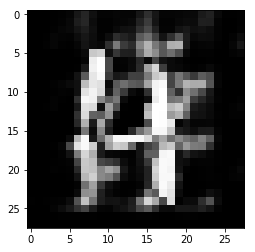

0.75086 0.163171


In [22]:

plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [23]:
for i in range(5000) :
    _ , loss = sess.run([residual_optim,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss)

0.163171
0.103731
0.0866524
0.0799494
0.0763867
0.0740623
0.0714699
0.0664315
0.0616251
0.0584399
0.0555374
0.0521603
0.0443268
0.0407734
0.0385672
0.0369101
0.0355883
0.0344839
0.0334713
0.0326335
0.0319095
0.0313324
0.0308252
0.0303608
0.0299255
0.0295511
0.0292432
0.0289152
0.0285666
0.0282978
0.028053
0.0277903
0.0275846
0.0273728
0.0271846
0.0269565
0.0267502
0.0265397
0.026315
0.0261021
0.0258731
0.0256533
0.0253353
0.0249713
0.0244504
0.0238835
0.0233468
0.0228797
0.0224359
0.0221149


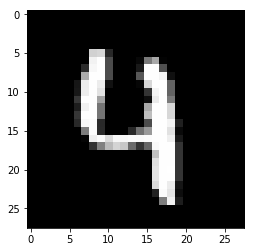

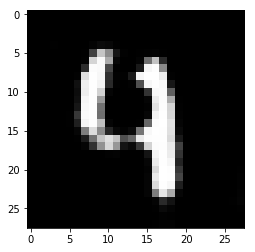

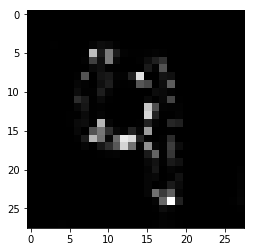

0.16605 0.0218917


In [24]:
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([feature_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)